In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
from sqlite3 import Error
import seaborn as sns
sns.set(style='whitegrid')

In [2]:
def create_connection(db_file):
    """ create a database connection to a SQLite database """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()

In [3]:
# This creates the final database if it doens't exist, and checks a connection to it if it does exist.
create_connection('Milestone5.db')

2.6.0


In [4]:
# These csvs are from the other Milestone assignments that I have completed. I used the to_csv() function
# # with the index=False argument so that I could import them all into this assignment.
books = pd.read_csv('mybooks.csv')
movies = pd.read_csv('movies.csv')
games = pd.read_csv('games.csv')

In [5]:
# create the SQL table 'books' if it doesn't exist already
with sqlite3.connect("Milestone5.db") as conn:
    cursor = conn.cursor()
    cursor.execute(''' SELECT count(name) FROM sqlite_master WHERE type='table' AND name='books' ''')
    if cursor.fetchone()[0] == 1:
        pass
    else:
        cursor.execute('CREATE TABLE books (BookID integer, Title text, Authors text, Score real, ISBN text, ISBN13 integer, Language text, Num_Pages integer, Ratings_Count integer, Text_Reviews_Count integer, Publication_Date integer, Publisher text, Type text)')
    books.to_sql('books', conn, if_exists = 'replace', index = False)
    conn.commit()


In [6]:
# Creates the table for 'movies' if it doesn't exist already
with sqlite3.connect("Milestone5.db") as conn:
    cursor = conn.cursor()
    cursor.execute(''' SELECT count(name) FROM sqlite_master WHERE type='table' AND name='movies' ''')
    if cursor.fetchone()[0] == 1:
        pass
    else:
        cursor.execute('CREATE TABLE movies (Rank integer, Title object, Release_Year integer, MPAA_Rating text, Length_min integer, Genres text, Score integer, Metascore real, Director text, Cast text, Score_Counts integer, Gross real, Cost_Score_Ratio real, Type text)')
    # fill 'movies' table with the values from pandas dataframe
    movies.to_sql('movies', conn, if_exists = 'replace', index = False)
    conn.commit()


In [7]:
# Creates the table for 'games' if it doesn't already exist
with sqlite3.connect("Milestone5.db") as conn:
    cursor = conn.cursor()
    cursor.execute(''' SELECT count(name) FROM sqlite_master WHERE type='table' AND name='games' ''')
    if cursor.fetchone()[0] == 1:
        pass
    else:
        cursor.execute('CREATE TABLE games (ID integer, Title text, Release_Date integer, Score integer, Score_Counts integer, Metascore real, Average_Playtime_Hours integer, Genre text, Platforms text, Online_Store_Sites text, Type text)')
    # fill 'games' table with the values from pandas dataframe
    games.to_sql('games', conn, if_exists = 'replace', index = False)
    conn.commit()


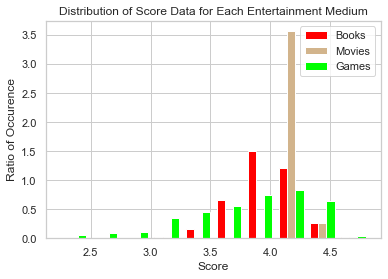

In [8]:
# Histogram showing the distribution of scores across the different mediums
with sqlite3.connect("Milestone5.db") as conn:
    cursor = conn.cursor()
    books_score_data = []
    movies_score_data = []
    games_score_data = []
    rows = cursor.execute('SELECT Score FROM books')
    for row in rows:
        books_score_data.append(row[0])
    rows = cursor.execute('SELECT Score FROM movies')
    for row in rows:
        movies_score_data.append(row[0]/2)
    rows = cursor.execute('SELECT Score FROM games')
    for row in rows:
        games_score_data.append(row[0])
score_data = [books_score_data, movies_score_data, games_score_data]

colors = ['red', 'tan', 'lime']
labels = ['Books', 'Movies', 'Games']

plt.hist(score_data, density = True, histtype = 'bar', color = colors, label=labels)
plt.title('Distribution of Score Data for Each Entertainment Medium')
plt.xlabel('Score')
plt.ylabel('Ratio of Occurence')
plt.legend()
plt.show()

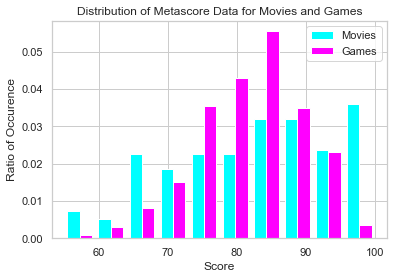

In [9]:
# Histogram comparing metacritic scores between Movies and Games (Books did not have a metacritic score)
with sqlite3.connect("Milestone5.db") as conn:
    cursor = conn.cursor()
    movies_metascore_data = []
    games_metascore_data = []
    rows = cursor.execute('SELECT Metascore FROM movies')
    for row in rows:
        movies_metascore_data.append(row[0])
    rows = cursor.execute('SELECT Metascore FROM games')
    for row in rows:
        games_metascore_data.append(row[0])
raw_metascore_data = [movies_metascore_data, games_metascore_data]
metascore_data = []
for data in raw_metascore_data:
    metascore_data.append([i for i in data if i])

colors = ['cyan', 'magenta']
labels = ['Movies', 'Games']

plt.hist(metascore_data, density = True, histtype = 'bar', color = colors, label=labels)
plt.title('Distribution of Metascore Data for Movies and Games')
plt.xlabel('Score')
plt.ylabel('Ratio of Occurence')
plt.legend()
plt.show()

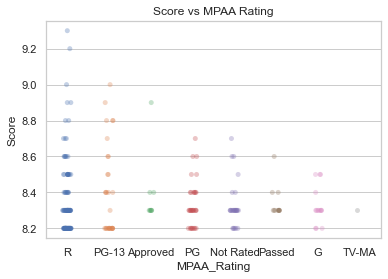

In [10]:
# A categorical scatterplot that shows the scores movies got and their ratings
with sqlite3.connect("Milestone5.db") as conn:
    scatter_data = pd.read_sql_query('SELECT Score, MPAA_Rating FROM movies', conn)
    scatter_data = scatter_data.dropna()


ax = sns.stripplot(x = 'MPAA_Rating', y = 'Score', data = scatter_data, alpha = .325)
ax.set(title = 'Score vs MPAA Rating')
plt.show()

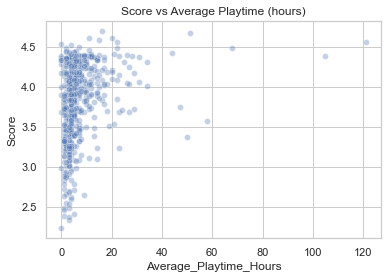

In [11]:
# A scatterplot that shows the average playtime in hours and the score that each game got
with sqlite3.connect("Milestone5.db") as conn:
    scatter_data2 = pd.read_sql_query('SELECT Score, Average_Playtime_Hours FROM games', conn)
ax = sns.scatterplot(x = 'Average_Playtime_Hours', y = 'Score', data = scatter_data2, alpha = .325)
ax.set(title = 'Score vs Average Playtime (hours)')
plt.show()

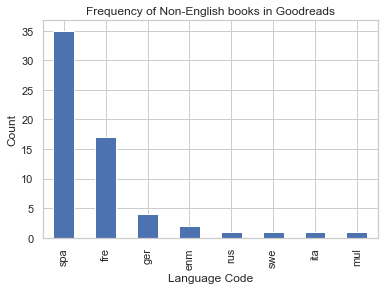

In [12]:
# Frequency Plot of Non-English Books from the Goodreads csv file
with sqlite3.connect("Milestone5.db") as conn:
    bar_data = pd.read_sql_query('SELECT Language FROM books', conn)
    bar_data['Language'] = bar_data['Language'].replace('en-US', 'eng')
    bar_data['Language'] = bar_data['Language'].replace('en-GB', 'eng')
    bar_data['Language'] = bar_data['Language'].replace('en-CA', 'eng')
    no_english = bar_data[bar_data['Language']!='eng']

plt.title('Frequency of Non-English books in Goodreads')
plt.xlabel('Language Code')
plt.ylabel('Count')
no_english['Language'].value_counts().plot(kind = 'bar')